In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
print(device)

cpu


In [5]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [6]:
class CustomMNISTDataset(Dataset):
  def __init__(self, csv_file, transform=None, is_test=False):
    self.data = pd.read_csv(csv_file)
    self.transform = transform
    self.is_test = is_test

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    item = self.data.iloc[idx]

    if self.is_test:
      image = item.values.reshape(28, 28).astype(np.uint8)
      label = None
    else:
      image = item[1:].values.reshape(28, 28).astype(np.uint8)
      label = item.iloc[0]

    image = transforms.ToPILImage()(image)

    if self.transform is not None:
      image = self.transform(image)

    if self.is_test:
      return image
    else:
      return image, label

In [7]:
transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [8]:
import os

# Path to the folder containing the dataset files
path = "/kaggle/input/digit-recognizer"

# List all files in that folder
files = os.listdir(path)
print(files)

['sample_submission.csv', 'train.csv', 'test.csv']


In [9]:
train_dataset = CustomMNISTDataset(csv_file=os.path.join(path, 'train.csv'), transform=transform, is_test=False)
test_dataset = CustomMNISTDataset(csv_file=os.path.join(path, 'test.csv'), transform=transform, is_test=True)

In [10]:
print('Train Size: ' + str(len(train_dataset)) +', Test Size: ' + str(len(test_dataset)))

Train Size: 42000, Test Size: 28000


In [11]:
train_dataset[1]

(tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.000

In [12]:
batch_size = 64
train_loader =torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader =torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Input Size: torch.Size([64, 1, 28, 28])


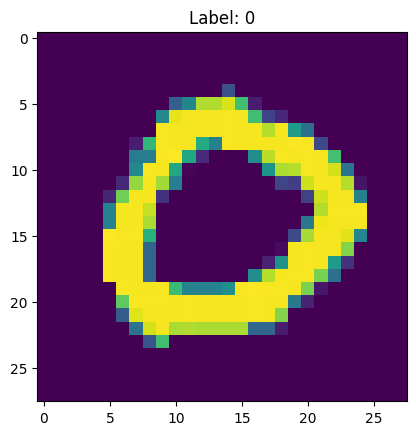

In [13]:
for example_data, example_labels in train_loader:
  example_image = example_data[0]
  print("Input Size:", example_data.size())

  example_image_numpy = example_image.permute(1, 2, 0).numpy()

  plt.imshow(example_image_numpy)
  plt.title(f'Label: {example_labels[0]}')
  plt.show()

  break

In [14]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        
        # Flattened size after conv + pool: 128*7*7
        self.fc1 = nn.Linear(128 * 7 * 7, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)  # 10 classes for MNIST

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        
        x = x.view(x.size(0), -1)  # flatten except batch dimension
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [15]:
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum = 0.9)

In [16]:
num_epochs = 100
running_loss = 0.0

for epoch in range(num_epochs):
  for i, data in enumerate(train_loader, 0):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()

    outputs = model(inputs.float())
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    if i % 100 == 99:
      print(f'Epoch: {epoch + 1}, Batch: {i + 1}, Loss: {running_loss / 100}')
      running_loss = 0.0

print('Finished Training')

Epoch: 1, Batch: 100, Loss: 2.2944100165367125
Epoch: 1, Batch: 200, Loss: 2.2681589984893797
Epoch: 1, Batch: 300, Loss: 2.1847637057304383
Epoch: 1, Batch: 400, Loss: 1.822020585536957
Epoch: 1, Batch: 500, Loss: 1.0970177394151688
Epoch: 1, Batch: 600, Loss: 0.7493681144714356
Epoch: 2, Batch: 100, Loss: 0.9320390084385872
Epoch: 2, Batch: 200, Loss: 0.48779209166765214
Epoch: 2, Batch: 300, Loss: 0.4609822969138622
Epoch: 2, Batch: 400, Loss: 0.42536938324570656
Epoch: 2, Batch: 500, Loss: 0.4014312508702278
Epoch: 2, Batch: 600, Loss: 0.3738798129558563
Epoch: 3, Batch: 100, Loss: 0.5362146762013436
Epoch: 3, Batch: 200, Loss: 0.3069046160578728
Epoch: 3, Batch: 300, Loss: 0.2972524520754814
Epoch: 3, Batch: 400, Loss: 0.28235703632235526
Epoch: 3, Batch: 500, Loss: 0.24787671700119973
Epoch: 3, Batch: 600, Loss: 0.2643126406520605
Epoch: 4, Batch: 100, Loss: 0.38802549421787264
Epoch: 4, Batch: 200, Loss: 0.23269206292927266
Epoch: 4, Batch: 300, Loss: 0.22017111539840697
Epoch: 

In [17]:
model.eval()
predictions = []

with torch.no_grad():
    for data in test_loader:      # use 'data' directly if no labels
        data = data.to(device)    # move to GPU/CPU

        outputs = model(data)     # forward pass
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().tolist())  # fixed typo

# Prepare submission
submission = pd.DataFrame({
    'ImageId': range(1, len(predictions) + 1),
    'Label': predictions
})

submission.to_csv('submission.csv', index=False)
print("Submission saved!")

Submission saved!


In [18]:
import zipfile

with zipfile.ZipFile('submission.zip', 'w') as z:
    z.write('submission.csv')

print("Zipped!")

Zipped!
